# Monetization workflow: first full implementation

This notebook is a first try at implementing the full monetization workflow:
1. Create a mapping that allows for subtracting impacts (i.e. that features activities on multiple levels).
2. Take a subset of that mapping, using a simple example structure and using only activities that are mapping to a single ecoinvent activity
3. Regionalize (using premise function?)
4. Calculate impacts, using subtraction approach C (see [approaches](https://pad.degrowth.net/SVQ10BiDR-ed7aX0oeOqiA#))
5. Get activity size from `fulldata.gdx`
6. Apply monetization factors
7. Money $$$

Note: There are a lot of details (e.g. hard coal / lignite mix) to be taken care of, and a lot of things to be refined (e.g. mappings) later.

## 1. Create mapping between REMIND and ecoinvent

Already present in an Excel sheet. Load it:

In [40]:
import pandas as pd
import numpy as np
import xarray as xr
import yaml
import brightway2 as bw
from premise.activity_maps import InventorySet, get_mapping
import wurst
from wurst import searching as ws
from premise.geomap import Geomap
import pickle

In [20]:
pe2se = pd.read_excel(
    "../mappings/mapping.xlsx", sheet_name="pe2se", nrows=48, 
    usecols=["abbreviation", "ecoinvent name", "mask name", "mask reference product"]
    )
pe2se

,abbreviation,ecoinvent name,mask name,mask reference product
0,pegas.seel.ngcc,"electricity production, natural gas, combined ...",NaN,NaN
1,pegas.seel.ngccc,"electricity production, at power plant/natural...",NaN,NaN
2,pegas.seel.ngt,"electricity production, natural gas, conventio...",NaN,NaN
3,pegas.segafos.gastr,NaN,NaN,NaN
4,pegas.seel.gaschp,"heat and power co-generation, natural gas, con...",NaN,NaN
5,pegas.sehe.gashp,"heat production, natural gas, at industrial fu...",NaN,NaN
6,pegas.seh2.gash2,"hydrogen production, auto-thermal reforming of...",NaN,NaN
7,pegas.seh2.gash2c,"hydrogen production, auto-thermal reforming of...",NaN,NaN
8,pegas.seliqfos.gasftrec,NaN,NaN,NaN
9,pegas.seliqfos.gasftcrec,NaN,NaN,NaN


In [21]:
pe_extraction = pd.read_excel(
    "../mappings/mapping.xlsx", sheet_name="pe extraction", nrows=12, 
    usecols=["entyPe", "ecoinvent name", "mask name", "mask reference product"]
    )
pe_extraction

,entyPe,ecoinvent name,mask name,mask reference product
0,peoil,"crude oil, at production; crude oil, at produc...",NaN,NaN
1,pegas,natural gas production,NaN,NaN
2,pecoal,hard coal mine operation and hard coal prepara...,NaN,NaN
3,peur,"uranium mine operation, open cast; uranium min...",NaN,NaN
4,pegeo,"deep well drilling, for deep geothermal power;...",NaN,NaN
5,pehyd,hydropower plant construction,NaN,NaN
6,pewin,wind turbine construction,NaN,NaN
7,pesol,concentrated solar power plant construction,NaN,NaN
8,pebiolc,hardwood forestry; softwood forestry,NaN,NaN
9,pebios,NaN,NaN,NaN


## 2. Subset of mapping

Take a subset of pe2se technologies.

In [22]:
some_pe2se = ["ngcc", "pc", "bioigcc", "geohdr", "tnrs", "spv"]
pe2se["tech"] = pe2se["abbreviation"].str.split(".").apply(lambda a: a[-1])
pe2se_subset = pe2se[pe2se["tech"].isin(some_pe2se)]
pe2se_subset

,abbreviation,ecoinvent name,mask name,mask reference product,tech
0,pegas.seel.ngcc,"electricity production, natural gas, combined ...",NaN,NaN,ngcc
14,pecoal.seel.pc,"Hard coal, burned in power plant/PC, no CCS; L...",NaN,NaN,pc
27,pebiolc.seel.bioigcc,"electricity production, at BIGCC power plant, ...",NaN,NaN,bioigcc
38,pegeo.seel.geohdr,"electricity production, deep geothermal",NaN,NaN,geohdr
43,pesol.seel.spv,"electricity production, photovoltaic, commercial",NaN,NaN,spv
46,peur.seel.tnrs,"electricity production, nuclear, pressure wate...",NaN,NaN,tnrs


Filter out unmapped PE extraction activities:

In [23]:
pe_extraction.dropna(axis=0, how="any", subset="ecoinvent name", inplace=True)
pe_extraction

,entyPe,ecoinvent name,mask name,mask reference product
0,peoil,"crude oil, at production; crude oil, at produc...",NaN,NaN
1,pegas,natural gas production,NaN,NaN
2,pecoal,hard coal mine operation and hard coal prepara...,NaN,NaN
3,peur,"uranium mine operation, open cast; uranium min...",NaN,NaN
4,pegeo,"deep well drilling, for deep geothermal power;...",NaN,NaN
5,pehyd,hydropower plant construction,NaN,NaN
6,pewin,wind turbine construction,NaN,NaN
7,pesol,concentrated solar power plant construction,NaN,NaN
8,pebiolc,hardwood forestry; softwood forestry,NaN,NaN


Create yaml files from mappings. At this stage, this is not strictly necessary, but as premise uses such yaml files and we want to use its features, we'll include this step here already.

In [24]:
def yaml_dict_from_dataframe(df, var_name="REMIND name"):
    ydict = {}

    for idx, row in df.iterrows():
        techname = row[var_name].strip()
        aliases = [a.strip() for a in row["ecoinvent name"].split(";")]

        # ecoinvent filters
        data = {
            "ecoinvent_aliases": {"fltr": aliases}
        }

        # ecoinvent masks
        if isinstance(row["mask name"], str):
            masks = [m.strip() for m in row["mask name"].split(";")]
            data["ecoinvent_aliases"].update(
                {"mask": {"name": masks}}
            )
        if isinstance(row["mask reference product"], str):
            masks = [m.strip() for m in row["mask reference product"].split(";")]
            data["ecoinvent_aliases"].update(
                {"mask": {"reference product": masks}}
            )

        ydict[techname] = data

    return ydict

In [25]:
import yaml

pe2se_dict = yaml_dict_from_dataframe(pe2se_subset, var_name="tech")
pe_extraction_dict = yaml_dict_from_dataframe(pe_extraction, var_name="entyPe")

yaml.dump(pe2se_dict, open("first_implementation_pe2se.yml", "w"))
yaml.dump(pe_extraction_dict, open("first_implementation_pe_extraction.yml", "w"))

## 3. Regionalize

The first step is to create a list of potential ecoinvent activities.

In [26]:
from premise.activity_maps import InventorySet, get_mapping
import brightway2 as bw

In [27]:
bw.projects.set_current("test")
eidb = bw.Database("ecoinvent_remind_default_2030")

In [28]:
mapping = InventorySet(eidb)

In [29]:
pe2se_filters = get_mapping("first_implementation_pe2se.yml", "ecoinvent_aliases")
pe_extraction_filters = get_mapping("first_implementation_pe_extraction.yml", "ecoinvent_aliases")

Note: The following part seems not perfectly streamlined. In premise there is `generate_sets_from_filters`, which only gives a dictionary with activity names as values, but for the proxies we need the reference product, too.

So probably we'll customize a bit here.

In [30]:
pe2se_activities = {
    tech: mapping.act_fltr(eidb, **fltr) for tech, fltr in pe2se_filters.items()
}
pe_extraction_activities = {
    tech: mapping.act_fltr(eidb, **fltr) for tech, fltr in pe_extraction_filters.items()
}

Now we have to find a proxy for each REMIND region.

In [31]:
import wurst
from wurst import searching as ws
from premise.geomap import Geomap

remind_regions = [
    "CAZ",
    "CHA",
    "EUR",
    "IND",
    "JPN",
    "LAM",
    "MEA",
    "NEU",
    "OAS",
    "REF",
    "SSA",
    "USA"
]

geo = Geomap(model="remind")
ecoinvent_to_iam_loc = {
            loc: geo.ecoinvent_to_iam_location(loc)
            for loc in list(set([a["location"] for a in eidb]))
        }

Code from `premise.transformation.py`, specifically the class `BaseTransformation`, but without changing the database (maybe later if we decide to create representative activities, we can fill in these parts).

In [32]:
def get_region_to_proxy_dataset_mapping(db, name, ref_prod, regions=None):
    d_map = {
            ecoinvent_to_iam_loc[d["location"]]: d["location"]
            for d in ws.get_many(
                db,
                ws.equals("name", name),
                ws.contains("reference product", ref_prod),
            )
            if d["location"] not in remind_regions
        }

    if not regions:
        regions = remind_regions

    if "RoW" in d_map.values():
        fallback_loc = "RoW"
    else:
        if "GLO" in d_map.values():
            fallback_loc = "GLO"
        else:
            fallback_loc = list(d_map.values())[0]

    return {region: d_map.get(region, fallback_loc) for region in regions}

def dataset_proxy(db, name, ref_prod, regions=None):
    d_iam_to_eco = get_region_to_proxy_dataset_mapping(
            db=db, name=name, ref_prod=ref_prod, regions=regions
        )

    d_act = {}

    ds_name, ds_ref_prod = [None, None]

    for region in d_iam_to_eco:

        try:
            dataset = ws.get_one(
                db,
                ws.equals("name", name),
                ws.contains("reference product", ref_prod),
                ws.equals("location", d_iam_to_eco[region]),
            )
        except ws.MultipleResults as err:
            print(
                err,
                "A single dataset was expected, "
                f"but found more than one for: {name, ref_prod}",
            )

        d_act[region] = dataset

    return d_act

Testing the adapted functions.

In [33]:
testname = pe2se_activities["ngcc"][0]["name"]
testprod = pe2se_activities["ngcc"][0]["reference product"]

dataset_proxy(eidb, testname, testprod)

{'CAZ': 'electricity production, natural gas, combined cycle power plant' (kilowatt hour, AU, None),
 'CHA': 'electricity production, natural gas, combined cycle power plant' (kilowatt hour, CN-AH, None),
 'EUR': 'electricity production, natural gas, combined cycle power plant' (kilowatt hour, AT, None),
 'IND': 'electricity production, natural gas, combined cycle power plant' (kilowatt hour, IN-MH, None),
 'JPN': 'electricity production, natural gas, combined cycle power plant' (kilowatt hour, JP, None),
 'LAM': 'electricity production, natural gas, combined cycle power plant' (kilowatt hour, CL, None),
 'MEA': 'electricity production, natural gas, combined cycle power plant' (kilowatt hour, TR, None),
 'NEU': 'electricity production, natural gas, combined cycle power plant' (kilowatt hour, NO, None),
 'OAS': 'electricity production, natural gas, combined cycle power plant' (kilowatt hour, KR, None),
 'REF': 'electricity production, natural gas, combined cycle power plant' (kilowatt h

Now apply them to the whole lot of technologies. For now, we just take the first activity that we got for each technology. So for example, we just take `Hard coal, burned in power plant/PC, no CCS` but not `Lignite, burned in power plant/PC, no CCS`. This is in principle a method of aggregating several ecoinvent activities into a mix; later, we'll use data to create these mixes.

In [34]:
all_activities = {}

for tech, actlst in pe2se_activities.items():
    name = actlst[0]["name"]
    ref_prod = actlst[0]["reference product"]

    all_activities[tech] = dataset_proxy(eidb, name, ref_prod)

for tech, actlst in pe_extraction_activities.items():
    name = actlst[0]["name"]
    ref_prod = actlst[0]["reference product"]

    all_activities[tech] = dataset_proxy(eidb, name, ref_prod)

Save activity key dictionary:

In [38]:
all_act_keys = {}
for tech, ddict in all_activities.items():
    data = {}
    for reg, act in ddict.items():
        data[reg] = act.key
    all_act_keys[tech] = data
all_act_keys

{'bioigcc': {'CAZ': ('ecoinvent_remind_default_2030',
   'b5878245699b41e2910b073031f4d3d6'),
  'CHA': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'EUR': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'IND': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'JPN': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'LAM': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'MEA': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'NEU': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'OAS': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'REF': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'SSA': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'USA': ('ecoinvent_remind_default_2030',
   'b5878245699b41e2910b073031f4d3d6')},
 'geohdr': {'CAZ': ('e

In [41]:
with open("all_act_keys.pkl", "wb") as f:
    pickle.dump(all_act_keys, f)

# 4. LCIA

Now we do the impact calculation. 

We'll apply the EF method, and subtract activities that we also assess using "approach C", so creating a technosphere where the respective products do not exist. (Note: It makes sense to later create a test for this subtraction. So testing that impacts are not negative, and maybe more.)

In [18]:
method_list = [
    "EF v3.0, acidification, accumulated exceedance (ae)",
    "EF v3.0, climate change, global warming potential (GWP100)",
    "EF v3.0, ecotoxicity: freshwater, comparative toxic unit for ecosystems (CTUe)",
    "EF v3.0, energy resources: non-renewable, abiotic depletion potential (ADP): fossil fuels",
    "EF v3.0, eutrophication: freshwater, fraction of nutrients reaching freshwater end compartment (P)",
    "EF v3.0, eutrophication: marine, fraction of nutrients reaching marine end compartment (N)",
    "EF v3.0, eutrophication: terrestrial, accumulated exceedance (AE)",
    "EF v3.0, human toxicity: carcinogenic, comparative toxic unit for human (CTUh)",
    "EF v3.0, human toxicity: non-carcinogenic, comparative toxic unit for human (CTUh)",
    "EF v3.0, ionising radiation: human health, human exposure efficiency relative to u235",
    "EF v3.0, land use, soil quality index",
    "EF v3.0, material resources: metals/minerals, abiotic depletion potential (ADP): elements (ultimate reserves)",
    "EF v3.0, ozone depletion, ozone depletion potential (ODP)",
    "EF v3.0, particulate matter formation, impact on human health",
    "EF v3.0, photochemical ozone formation: human health, tropospheric ozone concentration increase",
    "EF v3.0, water use, user deprivation potential (deprivation-weighted water consumption)"
]

midpoints = [m.split(",")[1].strip() for m in method_list]
midpoints

['acidification',
 'climate change',
 'ecotoxicity: freshwater',
 'energy resources: non-renewable',
 'eutrophication: freshwater',
 'eutrophication: marine',
 'eutrophication: terrestrial',
 'human toxicity: carcinogenic',
 'human toxicity: non-carcinogenic',
 'ionising radiation: human health',
 'land use',
 'material resources: metals/minerals',
 'ozone depletion',
 'particulate matter formation',
 'photochemical ozone formation: human health',
 'water use']

In [19]:
methods = []
for mp in midpoints:
    for m in bw.methods:
        if m[0] == "EF v3.0" and mp == m[1]:
            methods.append(m)
methods

[('EF v3.0', 'acidification', 'accumulated exceedance (ae)'),
 ('EF v3.0', 'climate change', 'global warming potential (GWP100)'),
 ('EF v3.0',
  'ecotoxicity: freshwater',
  'comparative toxic unit for ecosystems (CTUe) '),
 ('EF v3.0',
  'energy resources: non-renewable',
  'abiotic depletion potential (ADP): fossil fuels'),
 ('EF v3.0',
  'eutrophication: freshwater',
  'fraction of nutrients reaching freshwater end compartment (P)'),
 ('EF v3.0',
  'eutrophication: marine',
  'fraction of nutrients reaching marine end compartment (N)'),
 ('EF v3.0', 'eutrophication: terrestrial', 'accumulated exceedance (AE) '),
 ('EF v3.0',
  'human toxicity: carcinogenic',
  'comparative toxic unit for human (CTUh) '),
 ('EF v3.0',
  'human toxicity: non-carcinogenic',
  'comparative toxic unit for human (CTUh) '),
 ('EF v3.0',
  'ionising radiation: human health',
  'human exposure efficiency relative to u235'),
 ('EF v3.0', 'land use', 'soil quality index'),
 ('EF v3.0',
  'material resources: 

In [75]:
import numpy as np

impacts = []
techs = list(all_activities.keys())

counter = 0
for tech, actdict in all_activities.items():
    # create list of subtracted activities
    to_subtract = []
    for tech2, ddict in all_activities.items():
        if tech2 is not tech:
            to_subtract += list(ddict.values())

    temp1 = []
    counter1 = 0
    for reg, act in actdict.items():
        demand = {act: 1}
        lca = bw.LCA(demand=demand)
        lca.lci()

        # remove other products from technosphere
        i = []
        j = []
        for act in to_subtract:
            i.append(lca.product_dict[act.key])
            j.append(lca.activity_dict[act.key])
        i = list(set(i))
        j = list(set(j)) 
        lca.technosphere_matrix[i,:] = 0
        lca.technosphere_matrix[:,j] = 0

        # redo lci
        lca.lci_calculation()

        # calculate impacts
        temp2 = []
        counter2 = 0
        for m, mp in zip(methods, midpoints):
            lca.switch_method(m)
            lca.lcia()
            temp2.append(lca.score)
            counter2 += 1
            print("\t\t Method {} of {}. Score: {}".format(counter2, len(methods), lca.score))

        temp1.append(temp2)
        counter1 += 1
        print("\t Region {} of {}".format(counter1, len(remind_regions)))
    
    impacts.append(temp1)
    
    # print progress
    counter += 1
    print("{} of {} technologies done.".format(counter, len(techs)))

c:\Users\davidba\.conda\envs\bw2\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


		 Method 1 of 16. Score: 0.0015837293346566007
		 Method 2 of 16. Score: 0.17157109428809242
		 Method 3 of 16. Score: 4.105899525946495
		 Method 4 of 16. Score: 2.111822506397637
		 Method 5 of 16. Score: 1.4933962841098423e-05
		 Method 6 of 16. Score: 0.0006984077679497887
		 Method 7 of 16. Score: 0.007334011756110274
		 Method 8 of 16. Score: 1.515396115209446e-10
		 Method 9 of 16. Score: 3.58576599088438e-09
		 Method 10 of 16. Score: 0.015329722651669174
		 Method 11 of 16. Score: 3.005094008739594
		 Method 12 of 16. Score: 4.552360575241075e-06
		 Method 13 of 16. Score: 3.172375106533932e-08
		 Method 14 of 16. Score: 2.0134325026110358e-08
		 Method 15 of 16. Score: 0.0018662452956962957
		 Method 16 of 16. Score: 0.055069325678726806
	 Region 1 of 12
		 Method 1 of 16. Score: 0.0015837293346566007
		 Method 2 of 16. Score: 0.17157109428809242
		 Method 3 of 16. Score: 4.105899525946495
		 Method 4 of 16. Score: 2.111822506397637
		 Method 5 of 16. Score: 1.49339628410984

In [76]:
import xarray as xr

impacts_np = np.array(impacts)

impacts_xr = xr.DataArray(
    impacts_np,
    dims=["technology", "region", "midpoint"],
    coords = {
        "technology": techs,
        "region": remind_regions,
        "midpoint": midpoints
    }
)

impacts_xr

<xarray.DataArray (technology: 15, region: 12, midpoint: 16)>
array([[[1.58372933e-03, 1.71571094e-01, 4.10589953e+00, ...,
         2.01343250e-08, 1.86624530e-03, 5.50693257e-02],
        [1.58372933e-03, 1.71571094e-01, 4.10589953e+00, ...,
         2.01343250e-08, 1.86624530e-03, 5.50693257e-02],
        [1.58372933e-03, 1.71571094e-01, 4.10589953e+00, ...,
         2.01343250e-08, 1.86624530e-03, 5.50693257e-02],
        ...,
        [1.58372933e-03, 1.71571094e-01, 4.10589953e+00, ...,
         2.01343250e-08, 1.86624530e-03, 5.50693257e-02],
        [1.58372933e-03, 1.71571094e-01, 4.10589953e+00, ...,
         2.01343250e-08, 1.86624530e-03, 5.50693257e-02],
        [1.58372933e-03, 1.71571094e-01, 4.10589953e+00, ...,
         2.01343250e-08, 1.86624530e-03, 5.50693257e-02]],

       [[5.00745568e-06, 8.76217472e-04, 1.98287771e-02, ...,
         7.63993556e-11, 4.18188533e-06, 6.41369609e-04],
        [1.16320665e-05, 3.59194907e-03, 1.76094353e+00, ...,
         1.87152103e-10, 1.26298431e-05, 4.00982345e-03],
        [1.16320665e-05, 3.59194907e-03, 1.76094353e+00, ...,
         1.87152103e-10, 1.26298431e-05, 4.00982345e-03],
...
        [1.77308595e-01, 6.21353612e+00, 9.05761050e+03, ...,
         1.35801170e-06, 1.84921748e-01, 3.96743652e+01],
        [1.77308595e-01, 6.21353612e+00, 9.05761050e+03, ...,
         1.35801170e-06, 1.84921748e-01, 3.96743652e+01],
        [1.78370732e-01, 6.60465572e+00, 9.05900798e+03, ...,
         1.36920577e-06, 1.85163672e-01, 3.98318823e+01]],

       [[5.58117607e+03, 9.40144201e+05, 7.18385260e+07, ...,
         1.25306014e-01, 5.21696857e+03, 6.08477352e+05],
        [5.43101665e+03, 9.78311654e+05, 7.19266506e+07, ...,
         1.13075399e-01, 5.31015227e+03, 5.14887142e+05],
        [5.43101665e+03, 9.78311654e+05, 7.19266506e+07, ...,
         1.13075399e-01, 5.31015227e+03, 5.14887142e+05],
        ...,
        [5.43101665e+03, 9.78311654e+05, 7.19266506e+07, ...,
         1.13075399e-01, 5.31015227e+03, 5.14887142e+05],
        [5.43101665e+03, 9.78311654e+05, 7.19266506e+07, ...,
         1.13075399e-01, 5.31015227e+03, 5.14887142e+05],
        [5.43101665e+03, 9.78311654e+05, 7.19266506e+07, ...,
         1.13075399e-01, 5.31015227e+03, 5.14887142e+05]]])
Coordinates:
  * technology  (technology) <U7 'bioigcc' 'geohdr' 'ngcc' ... 'peur' 'pewin'
  * region      (region) <U3 'CAZ' 'CHA' 'EUR' 'IND' ... 'OAS' 'REF' 'SSA' 'USA'
  * midpoint    (midpoint) <U43 'acidification' 'climate change' ... 'water use'

Save the impact data for later:

In [77]:
impacts_xr.to_netcdf("impacts.nc")

Also calculate the impacts without subtraction:

In [20]:
impacts_doublecounting = []
techs = list(all_activities.keys())

counter = 0
for tech, actdict in all_activities.items():

    temp1 = []
    counter1 = 0
    for reg, act in actdict.items():
        demand = {act: 1}
        lca = bw.LCA(demand=demand)
        lca.lci()

        # calculate impacts
        temp2 = []
        counter2 = 0
        for m, mp in zip(methods, midpoints):
            lca.switch_method(m)
            lca.lcia()
            temp2.append(lca.score)
            counter2 += 1
            print("\t\t Method {} of {}. Score: {}".format(counter2, len(methods), lca.score))

        temp1.append(temp2)
        counter1 += 1
        print("\t Region {} of {}".format(counter1, len(remind_regions)))
    
    impacts_doublecounting.append(temp1)
    
    # print progress
    counter += 1
    print("{} of {} technologies done.".format(counter, len(techs)))

		 Method 1 of 16. Score: 0.0015932511878635452
		 Method 2 of 16. Score: 0.17541298998600574
		 Method 3 of 16. Score: 4.519942465516413
		 Method 4 of 16. Score: 2.357060543091843
		 Method 5 of 16. Score: 2.244786369110751e-05
		 Method 6 of 16. Score: 0.0007018119489944756
		 Method 7 of 16. Score: 0.007358675653118896
		 Method 8 of 16. Score: 1.5233091782120256e-10
		 Method 9 of 16. Score: 3.608923145113921e-09
		 Method 10 of 16. Score: 0.015871484510634554
		 Method 11 of 16. Score: 3.047522968713058
		 Method 12 of 16. Score: 4.561582430327629e-06
		 Method 13 of 16. Score: 3.178599670685909e-08
		 Method 14 of 16. Score: 2.0660751047386678e-08
		 Method 15 of 16. Score: 0.0018740343624166324
		 Method 16 of 16. Score: 0.05576137595648637
	 Region 1 of 12
		 Method 1 of 16. Score: 0.0015932511878635452
		 Method 2 of 16. Score: 0.17541298998600574
		 Method 3 of 16. Score: 4.519942465516413
		 Method 4 of 16. Score: 2.357060543091843
		 Method 5 of 16. Score: 2.24478636911075

In [21]:
import numpy as np
import xarray as xr

impacts_doublecounting_xr = xr.DataArray(
    np.array(impacts_doublecounting),
    dims=["technology", "region", "midpoint"],
    coords = {
        "technology": techs,
        "region": remind_regions,
        "midpoint": midpoints
    }
)

impacts_doublecounting_xr.to_netcdf("impacts_doublecounting.nc")

In [2]:
import xarray as xr

impacts_xr = xr.load_dataarray("impacts.nc")
impacts_doublecounting_xr = xr.load_dataarray("impacts_doublecounting.nc")

In [50]:
impacts_doublecounting_xr - impacts_xr

<xarray.DataArray (technology: 15, region: 12, midpoint: 16)>
array([[[ 9.52185321e-06,  3.84189570e-03,  4.14042940e-01, ...,
          5.26426021e-10,  7.78906672e-06,  6.92050278e-04],
        [ 9.52185321e-06,  3.84189570e-03,  4.14042940e-01, ...,
          5.26426021e-10,  7.78906672e-06,  6.92050278e-04],
        [ 9.52185321e-06,  3.84189570e-03,  4.14042940e-01, ...,
          5.26426021e-10,  7.78906672e-06,  6.92050278e-04],
        ...,
        [ 9.52185321e-06,  3.84189570e-03,  4.14042940e-01, ...,
          5.26426021e-10,  7.78906672e-06,  6.92050278e-04],
        [ 9.52185321e-06,  3.84189570e-03,  4.14042940e-01, ...,
          5.26426021e-10,  7.78906672e-06,  6.92050278e-04],
        [ 9.52185321e-06,  3.84189570e-03,  4.14042940e-01, ...,
          5.26426021e-10,  7.78906672e-06,  6.92050278e-04]],

       [[ 8.13067910e-05,  1.95341357e-02,  1.59993125e+01, ...,
          1.38475560e-09,  7.87438751e-05,  5.63194996e-02],
        [ 7.77596252e-05,  2.63036262e-02,  1.43339597e+01, ...,
          1.30934051e-09,  8.31566642e-05,  1.95622508e-02],
        [ 7.77596252e-05,  2.63036262e-02,  1.43339597e+01, ...,
          1.30934051e-09,  8.31566642e-05,  1.95622508e-02],
...
        [ 4.41482858e-04,  1.61992478e-01,  2.16504693e+01, ...,
          2.74020294e-08,  3.61672370e-04,  2.85604727e-02],
        [ 4.41482858e-04,  1.61992478e-01,  2.16504693e+01, ...,
          2.74020294e-08,  3.61672370e-04,  2.85604727e-02],
        [ 7.67413236e-04,  2.09708677e-01,  4.20937542e+01, ...,
          2.75850915e-08,  6.86094254e-04,  3.08952497e-02]],

       [[-2.72413091e+03, -5.14831371e+05, -4.23056770e+07, ...,
         -5.79111209e-02, -2.69108632e+03, -3.10768389e+05],
        [-2.80231080e+03, -5.21115638e+05, -4.23848994e+07, ...,
         -5.13163275e-02, -2.71455487e+03, -2.66942439e+05],
        [-2.80231080e+03, -5.21115638e+05, -4.23848994e+07, ...,
         -5.13163275e-02, -2.71455487e+03, -2.66942439e+05],
        ...,
        [-2.80231080e+03, -5.21115638e+05, -4.23848994e+07, ...,
         -5.13163275e-02, -2.71455487e+03, -2.66942439e+05],
        [-2.80231080e+03, -5.21115638e+05, -4.23848994e+07, ...,
         -5.13163275e-02, -2.71455487e+03, -2.66942439e+05],
        [-2.80231080e+03, -5.21115638e+05, -4.23848994e+07, ...,
         -5.13163275e-02, -2.71455487e+03, -2.66942439e+05]]])
Coordinates:
  * midpoint    (midpoint) object 'acidification' ... 'water use'
  * technology  (technology) object 'bioigcc' 'geohdr' 'ngcc' ... 'peur' 'pewin'
  * region      (region) object 'CAZ' 'CHA' 'EUR' 'IND' ... 'REF' 'SSA' 'USA'

# 5. Production amounts

Here, we need to go through a `fulldata.gdx` file. We use different variables to get the production values:
- pe2se: from `vm_prodSE`. Units are TWa.
- pe2extraction:
  - for `pecoal`, `pegas`, `pebiolc`, `peoil`, `peur` from `vm_prodPe`. Units are TWa and Mt Ur for `peur`.
  - for `pewin`, `pesol`, `pehyd`, `pegeo`: from `vm_deltaCap`. Units are TW.

Let us check the units of the mapped ecoinvent activities:

In [91]:
for tech, actdict in all_activities.items():
    act = actdict["NEU"]
    print("{}: Ref. product is \"{}\", measured in {}".format(
        tech,
        act["reference product"],
        act["unit"]
        )   
    )

bioigcc: Ref. product is "electricity, high voltage", measured in kilowatt hour
geohdr: Ref. product is "electricity, high voltage", measured in kilowatt hour
ngcc: Ref. product is "electricity, high voltage", measured in kilowatt hour
pc: Ref. product is "Hard coal, burned in power plant/PC, no CCS", measured in megajoule
spv: Ref. product is "electricity, low voltage", measured in kilowatt hour
tnrs: Ref. product is "electricity, high voltage", measured in kilowatt hour
pebiolc: Ref. product is "pulpwood, hardwood, measured as solid wood under bark", measured in cubic meter
pecoal: Ref. product is "hard coal", measured in kilogram
pegas: Ref. product is "natural gas, high pressure", measured in cubic meter
pegeo: Ref. product is "deep well, drilled, for geothermal power", measured in meter
pehyd: Ref. product is "hydropower plant, run-of-river", measured in unit
peoil: Ref. product is "crude oil, at production offshore", measured in kilogram
pesol: Ref. product is "concentrated solar

Note:
* Convert to electricity output in pc activity. There is a number in ecoinvent already.
* How to convert from wind turbine, hydropower plants, or concentrated solar power plant to PE? It's also rather the installed capacity that produces the impacts ...

So we define the conversion factors:

In [3]:
TWa2kWh = 8760 * 1e09
TWa2MJ = 1e06 * 8760 * 3600

prod_conversion = {
    "bioigcc": TWa2kWh,
    "geohdr": TWa2kWh,
    "ngcc": TWa2kWh,
    "pc": TWa2kWh * (1 / 7.83),
    "spv": TWa2kWh,
    "tnrs": TWa2kWh,
    "pebiolc": TWa2MJ / 7300,    # rough heating value from "Wood biomass as fuel"
    "pecoal": TWa2MJ / 32.5,    # heating value from wikipedia
    "pegas": TWa2MJ / 40,   # heating value from wikipedia
    "pegeo": (1e06 * 32000) / 5.5,   # 32000m needed for 5.5 MW plant (ecoinvent)
    "pehyd": 1e06 / 50,  # assuming a 50 MW plant
    "peoil": TWa2MJ / 45,    # heating value from world-nuclear.org
    "pesol": 1e06 / 50,
    "peur": 1e09,
    "pewin": 1e06 / 2.3
}

conversion_xr = xr.DataArray(
    np.array(list(prod_conversion.values())),
    coords=[list(prod_conversion.keys())],
    dims="technology"
)


Output relevant variables using `gdxdump`.

In [4]:
import subprocess

gdxpath = "../remind_data/fulldata.gdx"
for v in ["vm_deltaCap", "vm_prodSe", "vm_prodPe"]:
    args = [
        "gdxdump",
        gdxpath,
        "symb={}".format(v),
        "output={}.csv".format(v),
        "format=csv"
    ]
    subprocess.run(args)

Then read them in with pandas:

In [5]:
df = pd.read_csv("vm_deltaCap.csv")
df = df[df["all_te"].isin(["csp", "wind", "hydro", "geohdr"])]
df.replace({"wind": "pewin", "csp": "pesol", "geohdr": "pegeo", "hydro": "pehyd"}, inplace=True)
df = df.groupby(["tall", "all_regi", "all_te"]).sum()
df["Val"]

tall  all_regi  all_te
1900  CAZ       pegeo     0.000000e+00
                pehyd     0.000000e+00
                pesol     0.000000e+00
                pewin     0.000000e+00
      CHA       pegeo     0.000000e+00
                              ...     
2150  SSA       pewin     2.042533e-07
      USA       pegeo     0.000000e+00
                pehyd     0.000000e+00
                pesol     1.000000e-07
                pewin     1.904182e-07
Name: Val, Length: 1920, dtype: float64

In [6]:
vm_deltaCap = xr.DataArray.from_series(df["Val"])
mask = vm_deltaCap.coords["tall"] > 2000
vm_deltaCap = vm_deltaCap[mask,:,:]
vm_deltaCap

<xarray.DataArray 'Val' (tall: 19, all_regi: 12, all_te: 4)>
array([[[6.26761636e-05, 9.46110610e-04, 0.00000000e+00, 1.17467358e-04],
        [2.96618678e-06, 7.21438643e-03, 0.00000000e+00, 1.14269762e-04],
        [1.16820161e-04, 1.51000249e-03, 0.00000000e+00, 3.23305746e-03],
        [0.00000000e+00, 1.91283589e-03, 0.00000000e+00, 3.66898032e-04],
        [6.13429312e-05, 2.12383630e-04, 0.00000000e+00, 8.91407601e-05],
        [2.36442987e-04, 5.49319973e-03, 0.00000000e+00, 2.97487226e-05],
        [0.00000000e+00, 4.76427209e-04, 0.00000000e+00, 4.31511699e-05],
        [4.08750295e-05, 1.81834026e-03, 0.00000000e+00, 2.51132438e-05],
        [4.32726716e-04, 1.40071177e-03, 0.00000000e+00, 8.22566287e-06],
        [8.71504598e-06, 1.67375076e-03, 0.00000000e+00, 2.05595079e-06],
        [2.27512179e-05, 4.92962340e-04, 0.00000000e+00, 7.11507204e-07],
        [3.49914458e-04, 9.68880101e-04, 0.00000000e+00, 9.34681261e-04]],

       [[1.27940035e-04, 1.08581638e-03, 5.70514986e-07, 2.63394597e-03],
        [0.00000000e+00, 1.79513410e-02, 0.00000000e+00, 8.46445189e-03],
        [0.00000000e+00, 6.33882781e-03, 4.31490417e-04, 1.15995322e-02],
        [0.00000000e+00, 1.58352341e-03, 1.67670821e-05, 3.01398957e-03],
        [6.98917962e-05, 1.34843081e-03, 0.00000000e+00, 3.36366178e-04],
        [0.00000000e+00, 4.94712885e-03, 0.00000000e+00, 1.59080832e-03],
        [2.35506702e-06, 1.28237663e-03, 4.19776594e-05, 2.26524289e-04],
...
        [5.60570164e-10, 1.59658525e-03, 2.91676083e-03, 7.60207548e-02],
        [5.60570164e-10, 5.04815379e-05, 6.01904109e-03, 2.18901737e-01],
        [5.60570164e-10, 1.56807830e-03, 3.84564945e-06, 1.25312223e-02],
        [8.09316249e-04, 2.84840077e-04, 3.58342150e-05, 1.61310445e-01],
        [5.60570164e-10, 6.71369566e-04, 2.68431281e-03, 5.70553431e-02],
        [1.69391773e-04, 0.00000000e+00, 1.51397362e-02, 4.77228841e-01],
        [5.60570164e-10, 1.46941999e-03, 3.99701878e-03, 1.09416759e-01]],

       [[0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 1.00000000e-07],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 2.36807106e-07],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 1.00000000e-07],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 2.91051965e-07],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 1.00000000e-07],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 1.00000000e-07],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 4.24209531e-07],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 1.00000000e-07],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 1.00000000e-07],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 1.19730661e-07],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 2.04253282e-07],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 1.90418187e-07]]])
Coordinates:
  * tall      (tall) int64 2005 2010 2015 2020 2025 ... 2090 2100 2110 2130 2150
  * all_regi  (all_regi) object 'CAZ' 'CHA' 'EUR' 'IND' ... 'REF' 'SSA' 'USA'
  * all_te    (all_te) object 'pegeo' 'pehyd' 'pesol' 'pewin'

In [7]:
some_pe2se = ["ngcc", "pc", "bioigcc", "geohdr", "tnrs", "spv"]
df = pd.read_csv("vm_prodSe.csv")
df = df[df["all_te"].isin(some_pe2se)]
df = df.set_index(["tall", "all_regi", "all_te"])

In [8]:
vm_prodSe = xr.DataArray.from_series(df["Val"])
vm_prodSe

<xarray.DataArray 'Val' (tall: 19, all_regi: 12, all_te: 6)>
array([[[1.48499548e-03, 3.55437206e-04, 5.93833491e-03, 3.24102615e-02,
         1.06968084e-05, 1.03559454e-02],
        [9.35718672e-04, 1.26806131e-05, 5.66293944e-03, 2.35006497e-01,
         1.11322918e-05, 1.02613699e-02],
        [5.46592823e-03, 6.54761104e-04, 4.78626846e-02, 9.06332994e-02,
         1.77126497e-04, 1.21040330e-01],
        ...,
        [0.00000000e+00, 4.58943122e-05, 5.85780290e-03, 5.63089473e-03,
         0.00000000e+00, 2.69677145e-02],
        [1.46567954e-04, 1.12563291e-04, 2.06315104e-03, 2.65778355e-02,
         7.85586277e-07, 1.26737481e-03],
        [7.97980714e-03, 2.00283020e-03, 6.97076992e-02, 2.52373215e-01,
         6.25511606e-05, 9.67783184e-02]],

       [[1.73212847e-03, 7.57952681e-04, 7.83853893e-03, 2.84978539e-02,
         3.23701403e-04, 1.08790420e-02],
        [1.27531459e-03, 1.89144545e-05, 3.67121169e-06, 3.51115788e-01,
         6.15347332e-04, 1.03621529e-02],
        [6.40011493e-03, 8.98358938e-04, 6.83297298e-02, 6.88233427e-02,
         4.59927767e-03, 1.22247209e-01],
...
        [0.00000000e+00, 9.49692103e-05, 0.00000000e+00, 0.00000000e+00,
         2.82396506e-01, 0.00000000e+00],
        [0.00000000e+00, 2.25116236e-03, 0.00000000e+00, 0.00000000e+00,
         4.47095425e+00, 0.00000000e+00],
        [0.00000000e+00, 8.50000000e-09, 0.00000000e+00, 0.00000000e+00,
         7.70989625e-01, 0.00000000e+00]],

       [[0.00000000e+00, 8.50000000e-09, 0.00000000e+00, 0.00000000e+00,
         1.24724368e-01, 0.00000000e+00],
        [0.00000000e+00, 9.51300000e-05, 0.00000000e+00, 0.00000000e+00,
         6.69780412e-01, 0.00000000e+00],
        [0.00000000e+00, 8.50000000e-09, 0.00000000e+00, 0.00000000e+00,
         3.62308575e-01, 0.00000000e+00],
        ...,
        [0.00000000e+00, 8.50000000e-09, 0.00000000e+00, 0.00000000e+00,
         3.34076813e-01, 0.00000000e+00],
        [0.00000000e+00, 2.56851000e-03, 0.00000000e+00, 0.00000000e+00,
         3.97489150e+00, 0.00000000e+00],
        [0.00000000e+00, 8.50000000e-09, 0.00000000e+00, 0.00000000e+00,
         8.01163172e-01, 0.00000000e+00]]])
Coordinates:
  * tall      (tall) int64 2005 2010 2015 2020 2025 ... 2090 2100 2110 2130 2150
  * all_regi  (all_regi) object 'CAZ' 'CHA' 'EUR' 'IND' ... 'REF' 'SSA' 'USA'
  * all_te    (all_te) object 'bioigcc' 'geohdr' 'ngcc' 'pc' 'spv' 'tnrs'

In [9]:
df = pd.read_csv("vm_prodPe.csv")
df = df[df["all_enty"].isin(["pecoal", "pegas", "pebiolc", "peoil", "peur"])]
df = df.set_index(["ttot", "all_regi", "all_enty"])
df

Val
ttot all_regi all_enty          
2005 LAM      peoil     0.442880
              pegas     0.161835
              pecoal    0.056858
              peur      0.000728
              pebiolc   0.130630
...                          ...
2150 USA      peoil     0.000000
              pegas     0.017853
              pecoal    0.016838
              peur      0.000000
              pebiolc   0.450016

[1140 rows x 1 columns]

In [10]:
vm_prodPe = xr.DataArray.from_series(df["Val"])
vm_prodPe

<xarray.DataArray 'Val' (ttot: 19, all_regi: 12, all_enty: 5)>
array([[[3.00735059e-02, 1.15229635e-01, 1.06591338e-01, 2.06204838e-01,
         2.34828694e-03],
        [2.28707286e-01, 1.87965718e+00, 4.92751521e-02, 4.92380444e-01,
         2.32684124e-03],
        [1.32358527e-01, 5.07865789e-01, 5.86553717e-01, 1.06793284e+00,
         2.74467869e-02],
        ...,
        [1.48627106e-02, 3.09716619e-01, 6.19619404e-01, 2.41514562e-01,
         6.11512801e-03],
        [3.83904504e-01, 1.12182975e-01, 1.59780933e-02, 8.52756615e-02,
         2.87386577e-04],
        [9.77760915e-02, 7.83316646e-01, 6.30808120e-01, 1.25475469e+00,
         2.19451969e-02]],

       [[3.14979611e-02, 1.00178944e-01, 1.09505189e-01, 2.16136978e-01,
         2.46690295e-03],
        [2.03510696e-01, 2.42051389e+00, 8.06536332e-02, 6.39777240e-01,
         2.34969454e-03],
        [1.72226402e-01, 4.03464176e-01, 6.10829039e-01, 1.01779714e+00,
         2.77204556e-02],
...
        [3.05651564e-01, 1.97872705e-02, 1.65903253e-01, 4.52483844e-07,
         0.00000000e+00],
        [7.23859307e-01, 1.06750814e+00, 2.38800937e-01, 1.22858126e-01,
         0.00000000e+00],
        [4.65771904e-01, 1.82807046e-02, 2.18409807e-02, 0.00000000e+00,
         0.00000000e+00]],

       [[9.95067428e-02, 4.44694269e-03, 5.19513739e-03, 5.78289564e-07,
         0.00000000e+00],
        [4.30997449e-01, 3.71687462e-02, 5.81440829e-02, 0.00000000e+00,
         0.00000000e+00],
        [3.13826372e-01, 2.18303049e-02, 2.13467469e-02, 0.00000000e+00,
         0.00000000e+00],
        ...,
        [2.74373580e-01, 1.97927074e-02, 1.54966041e-02, 5.78289564e-07,
         0.00000000e+00],
        [9.64215568e-01, 7.44022289e-01, 2.01036144e-01, 7.82616285e-02,
         0.00000000e+00],
        [4.50015997e-01, 1.68378295e-02, 1.78527723e-02, 0.00000000e+00,
         0.00000000e+00]]])
Coordinates:
  * ttot      (ttot) int64 2005 2010 2015 2020 2025 ... 2090 2100 2110 2130 2150
  * all_regi  (all_regi) object 'CAZ' 'CHA' 'EUR' 'IND' ... 'REF' 'SSA' 'USA'
  * all_enty  (all_enty) object 'pebiolc' 'pecoal' 'pegas' 'peoil' 'peur'

In [11]:
vm_prodPe.rename({"all_enty": "technology"})

<xarray.DataArray 'Val' (ttot: 19, all_regi: 12, technology: 5)>
array([[[3.00735059e-02, 1.15229635e-01, 1.06591338e-01, 2.06204838e-01,
         2.34828694e-03],
        [2.28707286e-01, 1.87965718e+00, 4.92751521e-02, 4.92380444e-01,
         2.32684124e-03],
        [1.32358527e-01, 5.07865789e-01, 5.86553717e-01, 1.06793284e+00,
         2.74467869e-02],
        ...,
        [1.48627106e-02, 3.09716619e-01, 6.19619404e-01, 2.41514562e-01,
         6.11512801e-03],
        [3.83904504e-01, 1.12182975e-01, 1.59780933e-02, 8.52756615e-02,
         2.87386577e-04],
        [9.77760915e-02, 7.83316646e-01, 6.30808120e-01, 1.25475469e+00,
         2.19451969e-02]],

       [[3.14979611e-02, 1.00178944e-01, 1.09505189e-01, 2.16136978e-01,
         2.46690295e-03],
        [2.03510696e-01, 2.42051389e+00, 8.06536332e-02, 6.39777240e-01,
         2.34969454e-03],
        [1.72226402e-01, 4.03464176e-01, 6.10829039e-01, 1.01779714e+00,
         2.77204556e-02],
...
        [3.05651564e-01, 1.97872705e-02, 1.65903253e-01, 4.52483844e-07,
         0.00000000e+00],
        [7.23859307e-01, 1.06750814e+00, 2.38800937e-01, 1.22858126e-01,
         0.00000000e+00],
        [4.65771904e-01, 1.82807046e-02, 2.18409807e-02, 0.00000000e+00,
         0.00000000e+00]],

       [[9.95067428e-02, 4.44694269e-03, 5.19513739e-03, 5.78289564e-07,
         0.00000000e+00],
        [4.30997449e-01, 3.71687462e-02, 5.81440829e-02, 0.00000000e+00,
         0.00000000e+00],
        [3.13826372e-01, 2.18303049e-02, 2.13467469e-02, 0.00000000e+00,
         0.00000000e+00],
        ...,
        [2.74373580e-01, 1.97927074e-02, 1.54966041e-02, 5.78289564e-07,
         0.00000000e+00],
        [9.64215568e-01, 7.44022289e-01, 2.01036144e-01, 7.82616285e-02,
         0.00000000e+00],
        [4.50015997e-01, 1.68378295e-02, 1.78527723e-02, 0.00000000e+00,
         0.00000000e+00]]])
Coordinates:
  * ttot        (ttot) int64 2005 2010 2015 2020 2025 ... 2100 2110 2130 2150
  * all_regi    (all_regi) object 'CAZ' 'CHA' 'EUR' 'IND' ... 'REF' 'SSA' 'USA'
  * technology  (technology) object 'pebiolc' 'pecoal' 'pegas' 'peoil' 'peur'

In [12]:
production = xr.concat(
    [vm_prodPe.rename({"all_enty": "technology", "all_regi": "region", "ttot": "year"}),
    vm_prodSe.rename({"all_te": "technology", "all_regi": "region", "tall": "year"}),
    vm_deltaCap.rename({"all_te": "technology", "all_regi": "region", "tall": "year"})],
    dim="technology"
)


production

<xarray.DataArray 'Val' (year: 19, region: 12, technology: 15)>
array([[[3.00735059e-02, 1.15229635e-01, 1.06591338e-01, ...,
         9.46110610e-04, 0.00000000e+00, 1.17467358e-04],
        [2.28707286e-01, 1.87965718e+00, 4.92751521e-02, ...,
         7.21438643e-03, 0.00000000e+00, 1.14269762e-04],
        [1.32358527e-01, 5.07865789e-01, 5.86553717e-01, ...,
         1.51000249e-03, 0.00000000e+00, 3.23305746e-03],
        ...,
        [1.48627106e-02, 3.09716619e-01, 6.19619404e-01, ...,
         1.67375076e-03, 0.00000000e+00, 2.05595079e-06],
        [3.83904504e-01, 1.12182975e-01, 1.59780933e-02, ...,
         4.92962340e-04, 0.00000000e+00, 7.11507204e-07],
        [9.77760915e-02, 7.83316646e-01, 6.30808120e-01, ...,
         9.68880101e-04, 0.00000000e+00, 9.34681261e-04]],

       [[3.14979611e-02, 1.00178944e-01, 1.09505189e-01, ...,
         1.08581638e-03, 5.70514986e-07, 2.63394597e-03],
        [2.03510696e-01, 2.42051389e+00, 8.06536332e-02, ...,
         1.79513410e-02, 0.00000000e+00, 8.46445189e-03],
        [1.72226402e-01, 4.03464176e-01, 6.10829039e-01, ...,
         6.33882781e-03, 4.31490417e-04, 1.15995322e-02],
...
        [3.05651564e-01, 1.97872705e-02, 1.65903253e-01, ...,
         6.71369566e-04, 2.68431281e-03, 5.70553431e-02],
        [7.23859307e-01, 1.06750814e+00, 2.38800937e-01, ...,
         0.00000000e+00, 1.51397362e-02, 4.77228841e-01],
        [4.65771904e-01, 1.82807046e-02, 2.18409807e-02, ...,
         1.46941999e-03, 3.99701878e-03, 1.09416759e-01]],

       [[9.95067428e-02, 4.44694269e-03, 5.19513739e-03, ...,
         0.00000000e+00, 1.00000000e-07, 1.00000000e-07],
        [4.30997449e-01, 3.71687462e-02, 5.81440829e-02, ...,
         0.00000000e+00, 1.00000000e-07, 2.36807106e-07],
        [3.13826372e-01, 2.18303049e-02, 2.13467469e-02, ...,
         0.00000000e+00, 1.00000000e-07, 1.00000000e-07],
        ...,
        [2.74373580e-01, 1.97927074e-02, 1.54966041e-02, ...,
         0.00000000e+00, 1.00000000e-07, 1.19730661e-07],
        [9.64215568e-01, 7.44022289e-01, 2.01036144e-01, ...,
         0.00000000e+00, 1.00000000e-07, 2.04253282e-07],
        [4.50015997e-01, 1.68378295e-02, 1.78527723e-02, ...,
         0.00000000e+00, 1.00000000e-07, 1.90418187e-07]]])
Coordinates:
  * year        (year) int64 2005 2010 2015 2020 2025 ... 2100 2110 2130 2150
  * region      (region) object 'CAZ' 'CHA' 'EUR' 'IND' ... 'REF' 'SSA' 'USA'
  * technology  (technology) object 'pebiolc' 'pecoal' ... 'pesol' 'pewin'

# 6. Apply monetization factors

First load the Trinomics factors:

In [13]:
MFs = pd.read_excel("../monetization_factors/trinomics.xlsx")
MFs = MFs.set_index(["Midpoint"])
MFs

,unit,approach,Costs approach,low,central,high
Midpoint,,,,,,
climate change,kg CO2 eq,DG Move,Avoidance costs,6.150000e-02,0.102500,1.936000e-01
ozone depletion,kg CFC-11 eq,Env. Prices Handbook EU28,Damage costs,2.280000e+01,31.400000,1.272000e+02
ionising radiation: human health,kBq U235 eq,Env. Prices Handbook EU28,Damage costs,8.000000e-04,0.001200,4.610000e-02
photochemical ozone formation: human health,kg NMVOC eq,Env. Prices Handbook EU28,Damage costs,8.700000e-01,1.190000,1.900000e+00
particulate matter formation,Disease incidence,Env. Prices Handbook EU28 & UNEP 2016,Damage costs,6.619740e+05,784126.000000,1.204600e+06
human toxicity: non-carcinogenic,CTUh,JRC – based on DG Move and other studies,Damage costs,3.021100e+04,163447.000000,7.552700e+05
human toxicity: carcinogenic,CTUh,JRC – based on DG Move and other studies,Damage costs,1.743240e+05,902616.000000,2.789181e+06
acidification,mol H+ eq,OVAM,Damage & avoidance costs,1.760000e-01,0.344000,1.617000e+00
eutrophication: freshwater,kg P eq,Env. Prices Handbook EU28,Damage costs,2.600000e-01,1.920000,2.180000e+00


In [14]:
method_list = [
    "EF v3.0, acidification, accumulated exceedance (ae)",
    "EF v3.0, climate change, global warming potential (GWP100)",
    "EF v3.0, ecotoxicity: freshwater, comparative toxic unit for ecosystems (CTUe)",
    "EF v3.0, energy resources: non-renewable, abiotic depletion potential (ADP): fossil fuels",
    "EF v3.0, eutrophication: freshwater, fraction of nutrients reaching freshwater end compartment (P)",
    "EF v3.0, eutrophication: marine, fraction of nutrients reaching marine end compartment (N)",
    "EF v3.0, eutrophication: terrestrial, accumulated exceedance (AE)",
    "EF v3.0, human toxicity: carcinogenic, comparative toxic unit for human (CTUh)",
    "EF v3.0, human toxicity: non-carcinogenic, comparative toxic unit for human (CTUh)",
    "EF v3.0, ionising radiation: human health, human exposure efficiency relative to u235",
    "EF v3.0, land use, soil quality index",
    "EF v3.0, material resources: metals/minerals, abiotic depletion potential (ADP): elements (ultimate reserves)",
    "EF v3.0, ozone depletion, ozone depletion potential (ODP)",
    "EF v3.0, particulate matter formation, impact on human health",
    "EF v3.0, photochemical ozone formation: human health, tropospheric ozone concentration increase",
    "EF v3.0, water use, user deprivation potential (deprivation-weighted water consumption)"
]

midpoints = [m.split(",")[1].strip() for m in method_list]
midpoints

['acidification',
 'climate change',
 'ecotoxicity: freshwater',
 'energy resources: non-renewable',
 'eutrophication: freshwater',
 'eutrophication: marine',
 'eutrophication: terrestrial',
 'human toxicity: carcinogenic',
 'human toxicity: non-carcinogenic',
 'ionising radiation: human health',
 'land use',
 'material resources: metals/minerals',
 'ozone depletion',
 'particulate matter formation',
 'photochemical ozone formation: human health',
 'water use']

In [15]:
MF_xr = xr.DataArray(
    np.array([MFs["low"], MFs["central"], MFs["high"]]).T,
    coords=[
        MFs.index.values,
        ["low", "central", "high"]
    ],
    dims=["midpoint", "estimate"]
)
MF_xr

<xarray.DataArray (midpoint: 16, estimate: 3)>
array([[6.150000e-02, 1.025000e-01, 1.936000e-01],
       [2.280000e+01, 3.140000e+01, 1.272000e+02],
       [8.000000e-04, 1.200000e-03, 4.610000e-02],
       [8.700000e-01, 1.190000e+00, 1.900000e+00],
       [6.619740e+05, 7.841260e+05, 1.204600e+06],
       [3.021100e+04, 1.634470e+05, 7.552700e+05],
       [1.743240e+05, 9.026160e+05, 2.789181e+06],
       [1.760000e-01, 3.440000e-01, 1.617000e+00],
       [2.600000e-01, 1.920000e+00, 2.180000e+00],
       [3.210000e+00, 3.210000e+00, 3.210000e+00],
       [         nan,          nan,          nan],
       [2.390000e-24, 3.820000e-05, 1.880000e-04],
       [8.700000e-05, 1.750000e-04, 3.490000e-04],
       [4.190000e-03, 4.990000e-03, 2.359000e-01],
       [0.000000e+00, 1.300000e-03, 6.800000e-03],
       [0.000000e+00, 1.640000e+00, 6.530000e+00]])
Coordinates:
  * midpoint  (midpoint) object 'climate change' ... 'material resources: met...
  * estimate  (estimate) <U7 'low' 'central' 'high'

Put everything together:

In [16]:
# convert product units
converted_production = conversion_xr * production

# scaled impacts
scaled_impacts = impacts_xr * converted_production

# monetized impacts
costs = scaled_impacts * MF_xr

Save the results.

In [18]:
costs.to_netcdf("costs.nc")
production.to_netcdf("production.nc")
converted_production.to_netcdf("converted_production.nc")
scaled_impacts.to_netcdf("scaled_impacts.nc")
MF_xr.to_netcdf("MF_xr.nc")
conversion_xr.to_netcdf("conversion_xr.nc")

In [161]:
costs.sel(estimate="central")

<xarray.DataArray (technology: 15, region: 12, midpoint: 16, year: 19)>
array([[[[7.08710132e+06, 8.26653691e+06, 8.69748769e+06, ...,
          1.74470082e+02, 0.00000000e+00, 0.00000000e+00],
         [2.28769027e+08, 2.66840774e+08, 2.80751707e+08, ...,
          5.63183013e+03, 0.00000000e+00, 0.00000000e+00],
         [2.04033237e+06, 2.37988453e+06, 2.50395258e+06, ...,
          5.02288507e+01, 0.00000000e+00, 0.00000000e+00],
         ...,
         [2.05377171e+08, 2.39556045e+08, 2.52044572e+08, ...,
          5.05597002e+03, 0.00000000e+00, 0.00000000e+00],
         [2.88898260e+07, 3.36976715e+07, 3.54543973e+07, ...,
          7.11209007e+02, 0.00000000e+00, 0.00000000e+00],
         [3.57469952e+06, 4.16960111e+06, 4.38697060e+06, ...,
          8.80018627e+01, 0.00000000e+00, 0.00000000e+00]],

        [[4.46569240e+06, 6.08640485e+06, 1.39842506e+07, ...,
          4.06652533e+01, 0.00000000e+00, 0.00000000e+00],
         [1.44150910e+08, 1.96466912e+08, 4.51406471e+08, ...,
          1.31265943e+03, 0.00000000e+00, 0.00000000e+00],
         [1.28564505e+06, 1.75223808e+06, 4.02597872e+06, ...,
          1.17072733e+01, 0.00000000e+00, 0.00000000e+00],
...
         [2.74287142e+04, 5.48602610e+06, 1.12271141e+07, ...,
          1.08074703e+10, 1.83972466e+10, 7.87399604e+03],
         [1.95481383e+03, 3.90982952e+05, 8.00143882e+05, ...,
          7.70236339e+08, 1.31115122e+09, 5.61170903e+02],
         [7.94811346e+02, 1.58970477e+05, 3.25331971e+05, ...,
          3.13171808e+08, 5.33103383e+08, 2.28167509e+02]],

        [[7.59233350e+05, 6.58598726e+06, 6.59697647e+06, ...,
          4.06244993e+07, 8.88782693e+07, 1.54675015e+02],
         [4.07508613e+07, 3.53494289e+08, 3.54084121e+08, ...,
          2.18046710e+09, 4.77042536e+09, 8.30197997e+03],
         [1.11657757e+06, 9.68577797e+06, 9.70193941e+06, ...,
          5.97450109e+07, 1.30710120e+08, 2.27475060e+02],
         ...,
         [3.60321091e+07, 3.12561364e+08, 3.13082896e+08, ...,
          1.92797958e+09, 4.21803323e+09, 7.34065093e+03],
         [2.56796817e+06, 2.22758993e+07, 2.23130683e+07, ...,
          1.37404951e+08, 3.00614517e+08, 5.23159993e+02],
         [1.04411490e+06, 9.05719883e+06, 9.07231144e+06, ...,
          5.58677315e+07, 1.22227409e+08, 2.12712583e+02]]]])
Coordinates:
  * midpoint    (midpoint) object 'acidification' ... 'water use'
  * technology  (technology) object 'bioigcc' 'geohdr' 'ngcc' ... 'peur' 'pewin'
  * region      (region) object 'CAZ' 'CHA' 'EUR' 'IND' ... 'REF' 'SSA' 'USA'
  * year        (year) int64 2005 2010 2015 2020 2025 ... 2100 2110 2130 2150
    estimate    <U7 'central'

## Visualize global costs

In [164]:


global_costs = costs.sel(estimate="central").sum(dim="region")
global_costs

<xarray.DataArray (technology: 15, midpoint: 16, year: 19)>
array([[[1.00380656e+08, 1.33795858e+08, 1.77747739e+08, ...,
         1.52693499e+03, 0.00000000e+00, 0.00000000e+00],
        [3.24025070e+09, 4.31888114e+09, 5.73763170e+09, ...,
         4.92889006e+04, 0.00000000e+00, 0.00000000e+00],
        [2.88989662e+07, 3.85189948e+07, 5.11724678e+07, ...,
         4.39595082e+02, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.90893191e+09, 3.87727134e+09, 5.15095327e+09, ...,
         4.42490625e+04, 0.00000000e+00, 0.00000000e+00],
        [4.09191227e+08, 5.45404796e+08, 7.24570032e+08, ...,
         6.22439051e+03, 0.00000000e+00, 0.00000000e+00],
        [5.06315159e+07, 6.74859816e+07, 8.96550970e+07, ...,
         7.70178602e+02, 0.00000000e+00, 0.00000000e+00]],

       [[4.48640354e+05, 6.63987041e+05, 8.84298166e+05, ...,
         5.85076172e+05, 5.53973500e+05, 5.23878114e+05],
        [4.03014474e+07, 5.94973229e+07, 7.89908948e+07, ...,
         5.38332681e+07, 5.09715212e+07, 4.82024212e+07],
        [9.16762180e+06, 1.33965575e+07, 1.69264145e+07, ...,
         9.83570808e+06, 9.31285620e+06, 8.80692274e+06],
...
        [7.91308677e+07, 7.54678315e+07, 7.71996047e+07, ...,
         1.32689617e+06, 0.00000000e+00, 0.00000000e+00],
        [1.63192878e+07, 1.55619713e+07, 1.59194729e+07, ...,
         2.74209519e+05, 0.00000000e+00, 0.00000000e+00],
        [1.46932801e+07, 1.40120720e+07, 1.43338302e+07, ...,
         2.46693728e+05, 0.00000000e+00, 0.00000000e+00]],

       [[4.03527471e+06, 3.00975220e+07, 5.20936316e+07, ...,
         7.55357834e+08, 1.23146056e+09, 1.68082182e+03],
        [2.16246710e+08, 1.60779006e+09, 2.79321844e+09, ...,
         4.05255604e+10, 6.60695848e+10, 8.99252845e+04],
        [5.93048369e+06, 4.41725066e+07, 7.65785594e+07, ...,
         1.11067282e+09, 1.81073952e+09, 2.46847579e+03],
        ...,
        [1.91872864e+08, 1.43655997e+09, 2.47532022e+09, ...,
         3.58666451e+10, 5.84726470e+10, 8.00797420e+04],
        [1.36339934e+07, 1.01472303e+08, 1.76075884e+08, ...,
         2.55412133e+09, 4.16401738e+09, 5.67265543e+03],
        [5.56962487e+06, 4.18442658e+07, 7.18085384e+07, ...,
         1.03980926e+09, 1.69515890e+09, 2.32872068e+03]]])
Coordinates:
  * midpoint    (midpoint) object 'acidification' ... 'water use'
  * technology  (technology) object 'bioigcc' 'geohdr' 'ngcc' ... 'peur' 'pewin'
  * year        (year) int64 2005 2010 2015 2020 2025 ... 2100 2110 2130 2150
    estimate    <U7 'central'

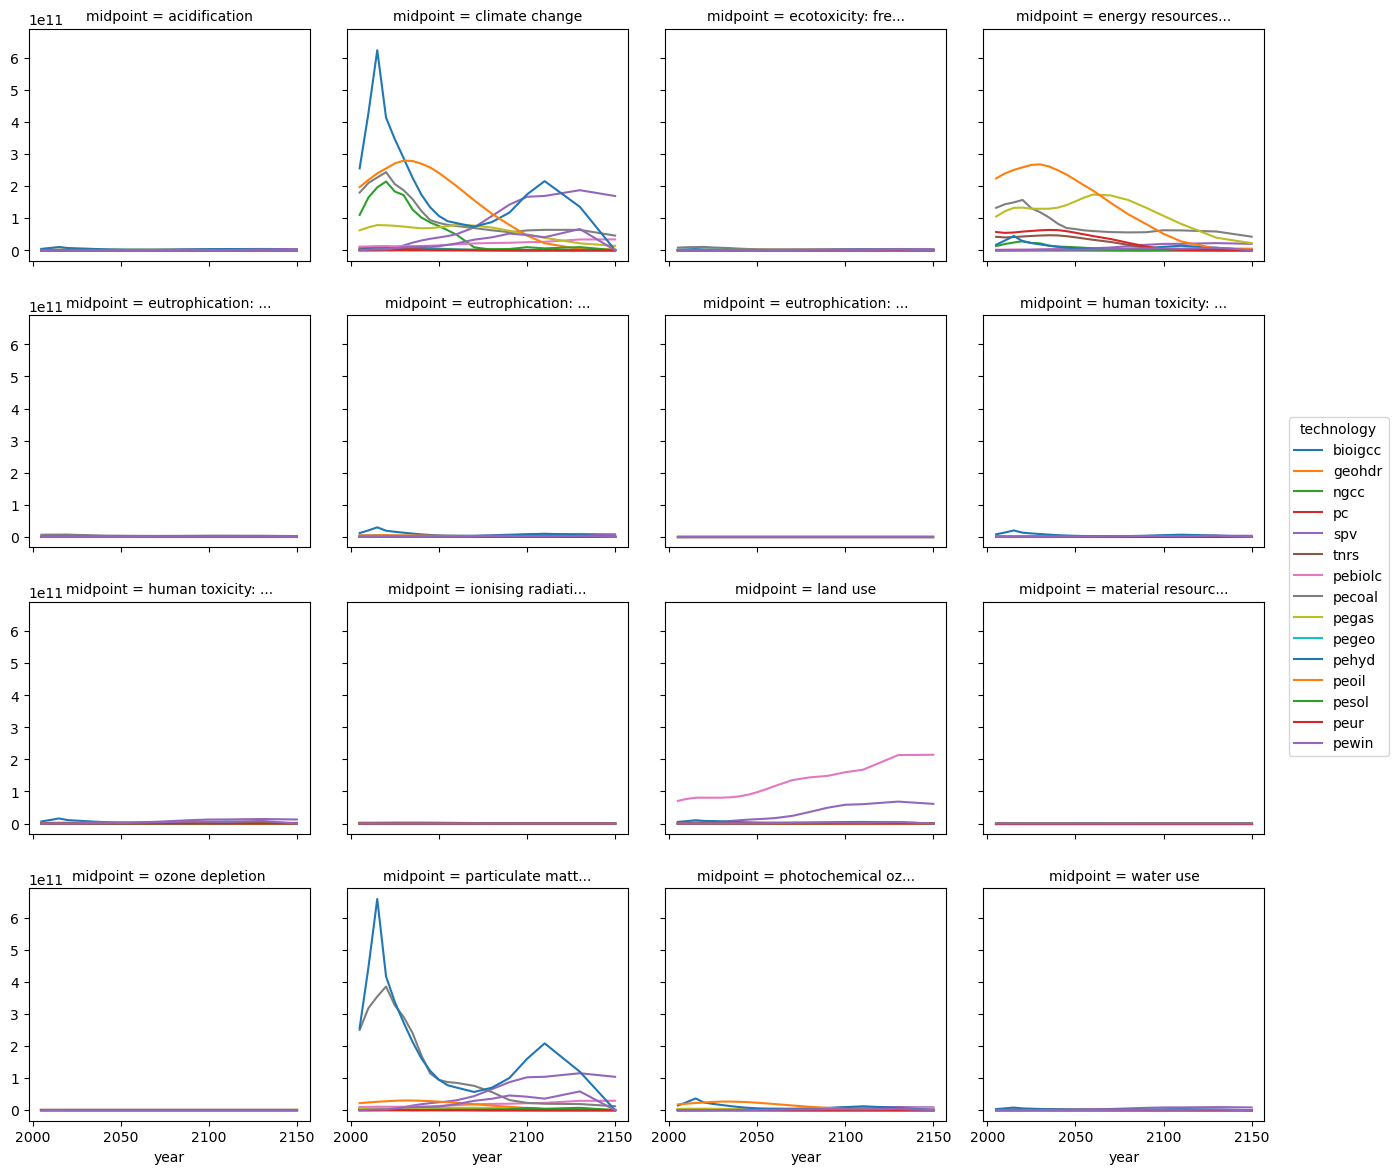

In [165]:
import matplotlib.pyplot as plt

global_costs.plot(x="year", hue="technology", col="midpoint", col_wrap=4)

In [174]:
data = global_costs.to_dataframe(name="global costs").drop("estimate", axis=1).reset_index()


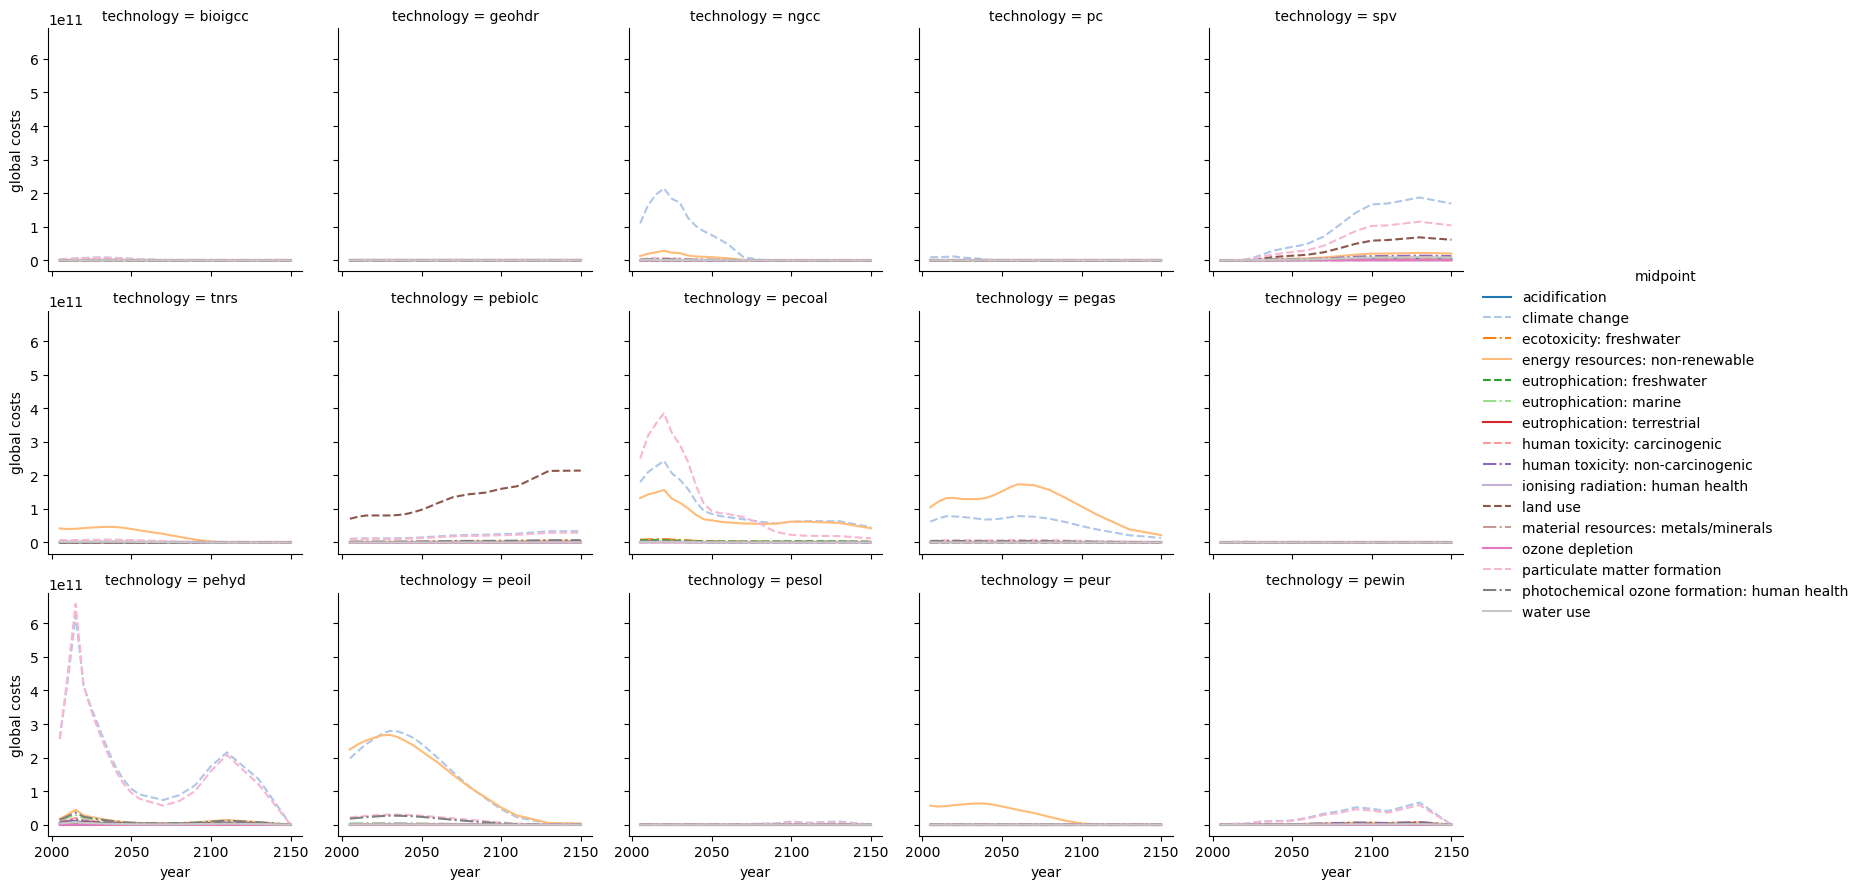

In [185]:
import seaborn as sns
from matplotlib import cm

hue_kws = {
    "color": cm.get_cmap("tab20").colors,
    "ls": (8*["-", "--", "-."])[:20]
}

sns.color_palette("Set1")
g = sns.FacetGrid(data, col="technology", col_wrap=5, hue="midpoint", hue_kws=hue_kws)
g.map(sns.lineplot, "year", "global costs")
g.add_legend()